Defining parameters
================

This notebook demonstrates how I typically define model parameters. The most critical parameter is the baseline, as this will affect all the statistics rasters produced by the algorithm. It is important to define a baseline period that reflects the conditions that are *expected* on the target date.

In [1]:
%matplotlib inline
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import re
from datetime import timedelta
import ee
ee.Initialize()
from s1flood import calc_basemean, calc_basesd, calc_zscore
from s1flood import mapFloods, floodPalette
import geemap
from geemap import ee_basemaps
from ipywidgets import Label

Use the map below to define an point of interest. An area around this point will be used to filter the Sentinel-1 ImageCollection and to centre the maps.

In [2]:
def parseClickedCoordinates(label):
    coords = [float(c) for c in re.findall(r'(?:-)?[0-9]+.[0-9]+', label.value)]
    coords.reverse()
    return coords

l = Label()
display(l)
def handle_interaction(**kwargs):
    if kwargs.get('type') == 'click':
        l.value = str(kwargs.get('coordinates'))

Map = geemap.Map(basemap = ee_basemaps['Esri Satellite'])
Map.on_interaction(handle_interaction)
Map

Label(value='')

Map(center=[40, -100], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [3]:
lon, lat = parseClickedCoordinates(l)
w, h = 1, 1 # search window in degrees

geometry = ee.Geometry.Polygon(
        [[[lon - w, lat - h],
          [lon - w, lat + h],
          [lon + w, lat + h],
          [lon + w, lat - h]]]
)

After clicking a location on the above map and parsing the coordinates in the cell above this one, we are now ready to set up our input Sentinel-1 collection. To do so, define your target date and the start and end of the baseline period. We might come back and change these based on our results below.

In [4]:
targdate = "2020-03-01"
basestart = "2019-09-15"
baseend = "2020-02-01"

filters = [
  ee.Filter.listContains("transmitterReceiverPolarisation", "VV"),
  ee.Filter.listContains("transmitterReceiverPolarisation", "VH"),
  ee.Filter.equals("instrumentMode", "IW"),
  ee.Filter.geometry(geometry),
  ee.Filter.date('2015-01-01', ee.Date(targdate).advance(1, 'day'))
  ]

Now with our filters set up, we can load the Sentinel-1 ImageCollection, filter it, and compute Z-scores for further analysis. We will compute the Z-scores descending orbit only. To include both orbital directions, run `calc_zscore()` independently for each orbital direction and merge the collections before proceeding.

In [5]:
s1 = ee.ImageCollection("COPERNICUS/S1_GRD").filter(filters)
z = calc_zscore(s1, basestart, baseend, 'IW', 'DESCENDING')

Once the Z-score map has loaded int he map below, click a location to extract its time series, which we will visualize in a minute.

In [6]:
Map = geemap.Map(basemap = geemap.ee_basemaps['Esri Satellite'])
Map.setCenter(lon, lat, 11)
Map.addLayer(s1.select('VV'), {'min': -25, 'max': 0}, 'VV Backscatter (dB); {0}'.format(targdate))
zpalette = ['#b2182b','#ef8a62','#fddbc7','#f7f7f7','#d1e5f0','#67a9cf','#2166ac']
Map.addLayer(z.select('VV'), {'min': -5, 'max': 5, 'palette': zpalette}, 'VV Z-score; {0}'.format(targdate))

label = Label()

def handle_interaction(**kwargs):
    if kwargs.get('type') == 'click':
        label.value = str(kwargs.get('coordinates'))
        
Map.on_interaction(handle_interaction)
Map

Map(center=[53.32196606454977, -9.043301790169826], controls=(ZoomControl(options=['position', 'zoom_in_text',…

The function below will extract the backscatter and Z-score time series from our ImageCollection and save them as a pandas DataFrame

In [7]:
def get_ts(p):
    x = s1.filter(ee.Filter.equals('instrumentMode', 'IW')) \
            .sort('system:time_start') \
            .getRegion(p, scale = 30) \
            .getInfo()
    xz = z.getRegion(p, scale = 30).getInfo()

    x = x[1:]
    xz = xz[1:]

    s1df = pd.DataFrame({
        'ID': [y[0] for y in x],
        'VV': [y[4] for y in x],
        'VH': [y[5] for y in x]
    })

    zdf = pd.DataFrame({
        'ID': [y[0] for y in xz],
        'ZVV': [y[4] for y in xz],
        'ZVH': [y[5] for y in xz]
    })

    def get_date(f):
        datestr = re.findall(r'[0-9]+T[0-9]+', f)[0]
        return datetime.strptime(datestr, "%Y%m%dT%H%M%S")

    s1df = s1df.assign(date = [get_date(i) for i in s1df['ID']])
    zdf = zdf.assign(date = [get_date(i) for i in zdf['ID']])
    df = s1df.merge(zdf, 'inner', on = 'date')[['date', 'VV', 'VH', 'ZVV', 'ZVH']]
    return df

In [8]:
coords = parseClickedCoordinates(label)
p = ee.Geometry.Point(coords)
df = get_ts(p).query("date > '2017-01-01'") # change this date to shorten/lengthen the time series panels below

Now we will use matplotlib to visualize the time series. The baseline period you defined above is shown as a light blue region in these time series. You can use this plot to chedck whether your baseline period is appropriate. For example, a high standard deviation within the baseline period will result in low absolute Z-scores, which may not "dampen" the signal during actual flood events.

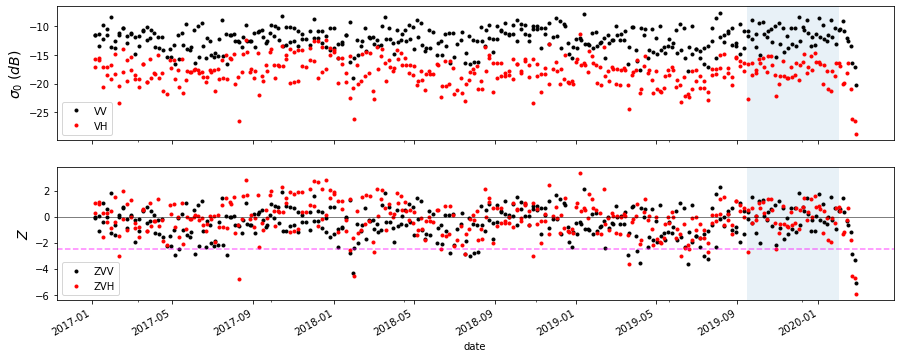

In [9]:
fig, ax = plt.subplots(2, 1, figsize = [15, 6], sharex = True)
df.plot(x = 'date', y = 'VV', ax = ax[0], style = 'k.')
df.plot(x = 'date', y = 'VH', ax = ax[0], style = 'r.')
df.plot(x = 'date', y = 'ZVV', ax = ax[1], style = 'k.')
df.plot(x = 'date', y = 'ZVH', ax = ax[1], style = 'r.')

ax[0].set_ylabel("$\sigma_{0}\;(dB)$", fontsize = 14)
ax[1].set_ylabel("$Z$", fontsize = 14)

# show baseline period
xy0 = datetime.strptime(basestart, "%Y-%m-%d"), ax[0].get_ylim()[0]
xy1 = datetime.strptime(basestart, "%Y-%m-%d"), ax[1].get_ylim()[0]
w = datetime.strptime(baseend, "%Y-%m-%d") - datetime.strptime(basestart, "%Y-%m-%d")
h0 = ax[0].get_ylim()[1] - ax[0].get_ylim()[0]
h1 = ax[1].get_ylim()[1] - ax[1].get_ylim()[0]
ax[0].add_patch(Rectangle(xy0, w, h0, alpha = 0.1))
ax[1].add_patch(Rectangle(xy1, w, h1, alpha = 0.1))

# show Z=0 line and an example Z-score threshold line
ax[1].axhline(0, c = 'black', linewidth = 0.5)
ax[1].axhline(-2.5, c = 'magenta', linestyle = '--', alpha = 0.5)

When you are satisfied with the parameters you have chosen, run the flood mapping algorithm.

In [11]:
zvv_thd = -2.5 # VV Z-score threshold
zvh_thd = -2.5 # VH Z-score threshold
pin_thd = 50 # historical P(inundation) threshold (%)
pow_thd = 90 # permanent open water threshold; historical P(open water) (%)

floods = mapFloods(z.mosaic(), zvv_thd, zvh_thd, use_dswe = True, pin_thd = pin_thd, pow_thd = pow_thd)
floods = floods.updateMask(floods.gt(0))
Map = geemap.Map(basemap = ee_basemaps['Esri Satellite'])
Map.addLayer(floods, {'min': 0, 'max': 20, 'palette': floodPalette}, "Flood Map, {0}".format(targdate))
Map.setCenter(coords[0], coords[1], 10)
Map

Map(center=[53.32475368137881, -9.054891096508285], controls=(ZoomControl(options=['position', 'zoom_in_text',…